<a href="https://colab.research.google.com/github/edgarriba/kornia-examples/blob/master/kornia_handson.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Hand-on in Computer Vision with Kornia and PyTorch**

In this short tutorial we are going to learn how to start implementing some computer vision techniques in Kornia and PyTorch using accelerated computing in with the GPU.

# **1. Install dependencies**

We need first to install Kornia, PyTorch for the processing and Torchvision, Matplotlib for visualisation.

In [ ]:
!pip install torch torchvision kornia matplotlib

In [2]:
import torch
import torchvision as tv
import kornia as K

import matplotlib.pyplot as plt

# **2. Load tensor images**

We define a couple of utilities to download images from the internet and load in memory with torchvision. 

In [3]:
import urllib.request

def download_image(query: str, out_name: str):
    urllib.request.urlretrieve(query, out_name)

download_image(
    "https://cdn.theculturetrip.com/wp-content/uploads/2016/05/girona_riverside_hdr.jpg", out_name="my_img.jpg"
)

Load the image using torchvision

In [5]:
img: torch.Tensor = tv.io.read_image("my_img.jpg")
img = img.float() / 255.  # Kornia needs normalized images between [0,1]

print(f"Downloaded image shape: {img.shape}")
print(f"Number of channels: {img.shape[0]}")
print(f"Number of rows: {img.shape[1]}")
print(f"Number of columns: {img.shape[2]}")

Downloaded image shape: torch.Size([3, 828, 1101])
Number of channels: 3
Number of rows: 828
Number of columns: 1101


Show the image with matplotlib

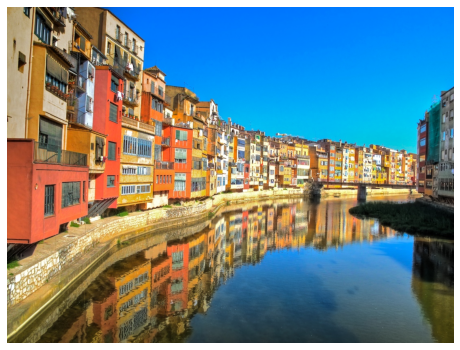

In [6]:
def show_image(img: torch.Tensor, size: [int, int]):
    # cast to numpy array before sending to matplotlib
    img_np: np.ndarray = K.tensor_to_image(img)

    plt.figure(figsize=size)
    plt.imshow(img_np)
    plt.axis('off')

show_image(img, (8, 8))

# **3. Create a batch of images**

Kornia uses PyTorch as its backend enabling to manipulate several images in parallel.

Let's create a batch of images.

torch.Size([1, 3, 828, 1101])
torch.Size([4, 3, 828, 1101])


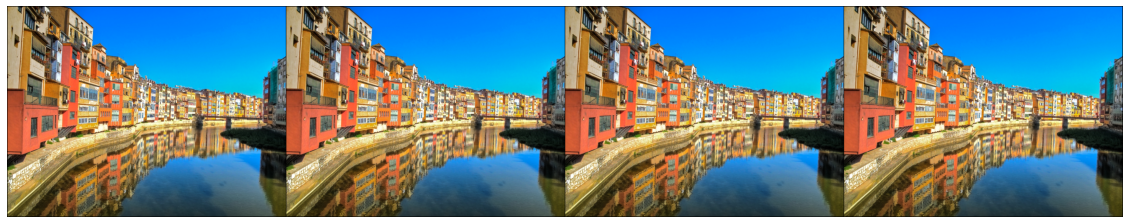

In [7]:
num_imgs: int = 4  # the number of images (or batch size)

img_batch: torch.Tensor = img.unsqueeze(0)  # CxHxW -> 1xCxHxW
print(img_batch.shape)

img_batch = img_batch.repeat(num_imgs, 1, 1, 1)  # BxCxHxW
print(img_batch.shape)

img_vis = tv.utils.make_grid(img_batch, 4)
show_image(img_vis, (20, 20))

# **4. Image processing (with CUDA)**

Now that we know how load images, the perform a simple image processing operation using the GPU.

*NOTE: make sure you have cuda available with* `torch.cuda.is_available()`

In [8]:
# check default image device is `cpu`
device: torch.device = img.device
print(f"Current image in device: {img.device}")

Current image in device: cpu


In [9]:
print(f"Do I have a GPU ? {torch.cuda.is_available()}")

# let's send the image to the GPU and define a cuda device
device_cu: torch.device = torch.device("cuda:0")
img_batch = img_batch.to(device_cu)

# this is equivalent to do .cuda()
img_batch = img_batch.cuda()
print(f"Current image in device: {img_batch.device}")

Do I have a GPU ? True
Current image in device: cuda:0


## Color

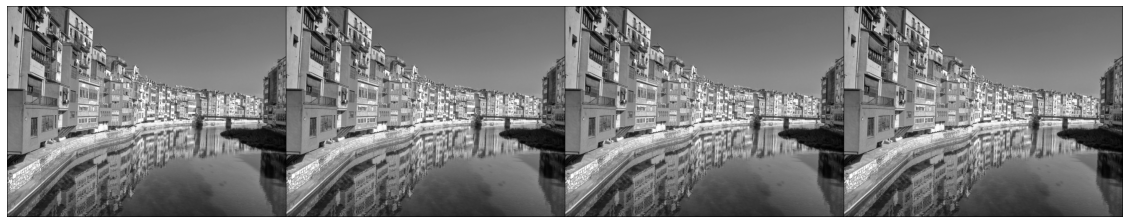

In [10]:
# apply any kornia.color function

img_out: torch.Tensor = K.color.rgb_to_grayscale(img_batch)

img_vis = tv.utils.make_grid(img_out, 4)
show_image(img_vis, (20, 20))

## Enhance

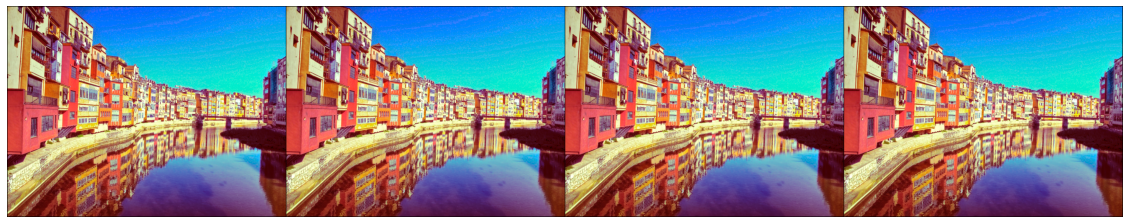

In [11]:
# apply any kornia.enhance function

img_out: torch.Tensor = K.enhance.equalize(img_batch)

img_vis = tv.utils.make_grid(img_out, 4)
show_image(img_vis, (20, 20))

## Filtering

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


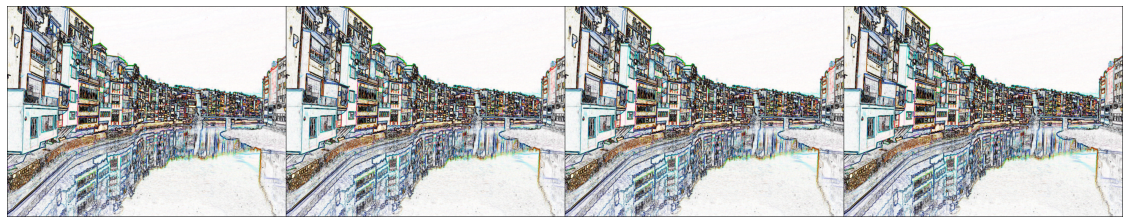

In [12]:
# apply any kornia.filters function

img_out: torch.Tensor = K.filters.sobel(img_batch, normalized=False)

img_vis = tv.utils.make_grid(1-img_out, 4)
show_image(img_vis, (20, 20))

# **5. BONUS: Computer Vision 2.0**

PyTorch provides the `torch.autograd` package that allow us to use automatic differentiation with any torch operator and compute for free the derivatives of complex functions.

Let's bring standard vision operations to differentiable programming paradigm.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


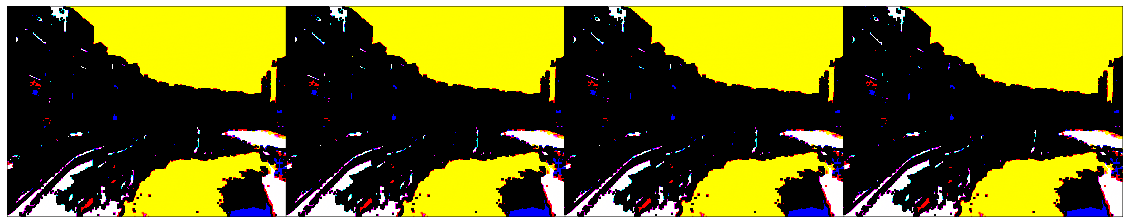

In [13]:
# define a combination of operations
img_rgb = img_batch.clone().requires_grad_(True)
img_hsv = K.color.rgb_to_hsv(img_rgb)
img_sob = K.filters.sobel(img_rgb)

img_out = ((img_hsv - img_rgb) ** img_sob).mean()
img_out.backward()

# show me the gradients
img_grad = img_rgb.grad

img_vis = tv.utils.make_grid(1-img_grad, 4)
show_image(img_vis, (20, 20))